# The following notebook applies unsupervised learning and clustering to the TESS simulated data. 

The following builds upon the previous notebook on clustering of transit data, incorporating clustering algorithms on top of the dimensionality reduction. Note this is a new dataset, which incorporates 3 different types of transits. 

2 of which are negatives such as binary stars, together with noise labelled as 0, and the positives labelled as 1.  

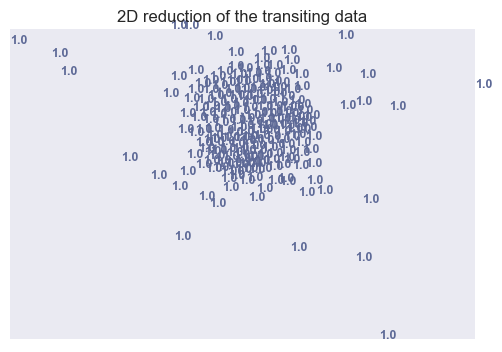

In [5]:
%matplotlib inline
# import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize

# clustering algorithm 
import hdbscan

# plotting function

def plot_embedding(X, Title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(Y[i]),
                 color=plt.cm.Set1(Y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if Title is not None:
        plt.title(Title)


# Section to read unbalanced 3 planets data set

balanced = np.loadtxt('three_planets_with_false_positives2.txt')
IDs = balanced[:, 1]
X = balanced[:, 3:]
Y = np.zeros(balanced.shape[0]) + 1
Y[balanced[:, 0] > 1] = 0

X_three_transiting_planets = X[:225, 3:]
Y_three_transiting_planets = Y[:225]

# using the settings we found successful from the previous notebook
tsne = TSNE(n_components=2, random_state=0)
svd = TSVD(n_components=50, random_state=0)

X_three_transiting_planets_reduced = tsne.fit_transform(svd.fit_transform(X_three_transiting_planets))

plot_embedding(X_three_transiting_planets_reduced, 
               Title='2D reduction of the transiting data')

Simply running them at default seems to show a strong central cluster, and points on the periphery.

Next we'll try using the settings that gave us good separations in the previous notebook. 

Note that in this notebook and the previous no axis lables or values are provided for the plot as they aren't nessessary, we are mostly interested in whether or not there is a visual distinction within the clusters. 

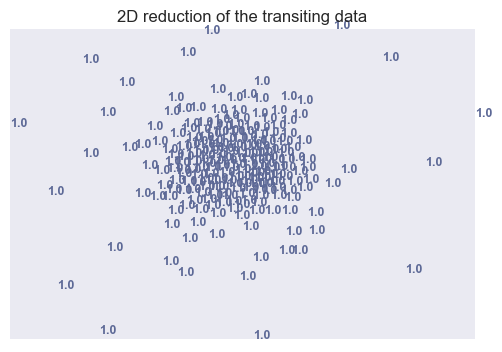

In [24]:
# using the settings we found successful from the previous notebook

tsne = TSNE(n_components=2, init='pca', method='exact', metric='manhattan')

# perform reduction
X_three_transiting_planets_reduced = tsne.fit_transform(svd.fit_transform(X_three_transiting_planets))

plot_embedding(X_three_transiting_planets_reduced, 
               Title='2D reduction of the transiting data')



We can see that it doesn't change much, however there is a clear distinction between a strong central cluster and points on the periphery. 

We can try applying hdbscan to the above to see if it picks up anything our eye doesn't.

There are 3 clusters


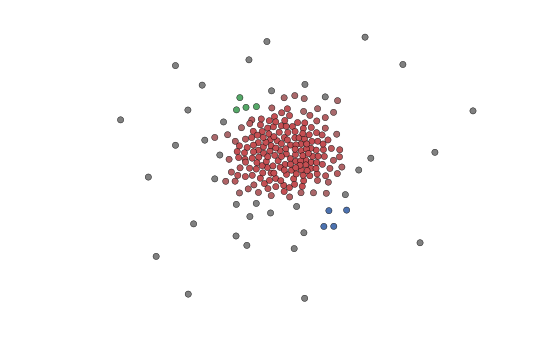

In [50]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=2).fit(X_three_transiting_planets_reduced)

palette = sns.color_palette()

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.axis('off')

plt.scatter(X_three_transiting_planets_reduced.T[0], X_three_transiting_planets_reduced.T[1],
            c = cluster_colors)

n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
print("There are {0} clusters").format(n_clusters_)
plt.show()

We can see that the central cluster can be filtered, however a couple smaller clusters get found and the rest of the peripheral points get classified as noise.

While its easy to understand why the points outside the central cluster can be classified as noise its hard to reason the the other 2 small cluseters. 

Overall, it is fair to say the lack of density and number of points is most likely the cause of any general meaningful results, as the spaces between the points are large enough that even by eye they don't appear to be clusters. 

At this point we'll integrate the first two classes of non planetary transits (0s).

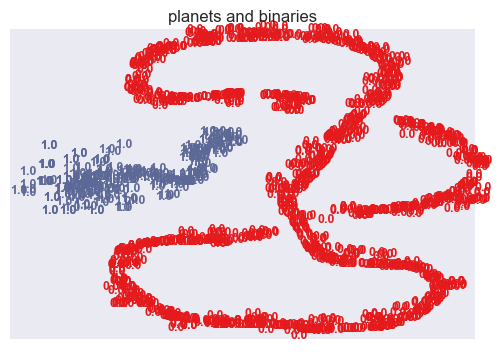

In [51]:
tsvd = TSVD(n_components=50, n_iter=10000, algorithm='arpack')

X_planets_and_binaries = tsne.fit_transform(tsvd.fit_transform(X[:1225, 3:]))
Y_planets_and_binaries = Y[:1225]
plot_embedding(X_planets_and_binaries, Title='planets and binaries')

There are 2 clusters


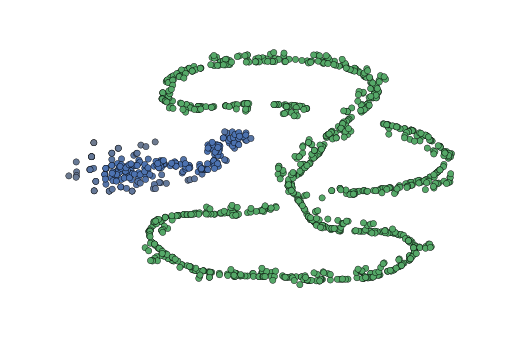

In [53]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=11).fit(X_planets_and_binaries)

palette = sns.color_palette()

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(X_planets_and_binaries.T[0], X_planets_and_binaries.T[1],
            c = cluster_colors)
plt.axis('off')

n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)

print("There are {0} clusters").format(n_clusters_)

plt.show()

We see that the clusterer correctly identifies the 2 clusters and also that these three clusters fall into the appropriate categories, however, it seems that some slicing appears to be occuring in the class of 0s... it seems that the green cluster is one stream that is getting divided down the centre. 

However typical datasets will be extremely noisey, so we'll extend our dataset to encompass all of the classes. 

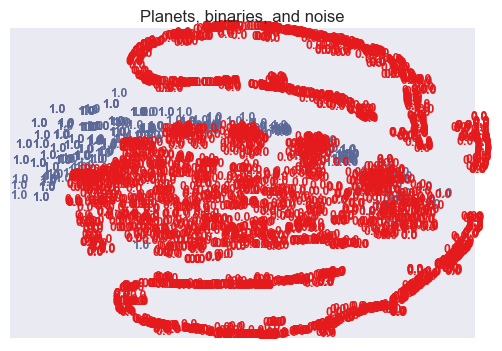

In [54]:
tsvd = TSVD(n_components=50, n_iter=10000, algorithm='arpack')
X_planets_binaries_noise = tsne.fit_transform(tsvd.fit_transform(X[:2225, 3:]))
plot_embedding(X_planets_binaries_noise, Title="Planets, binaries, and noise")

We can see that when fully including the noise it's quite a mess. Maybe it's due to the ratio of noise to data, we'll take a fraction out to see the effects. 

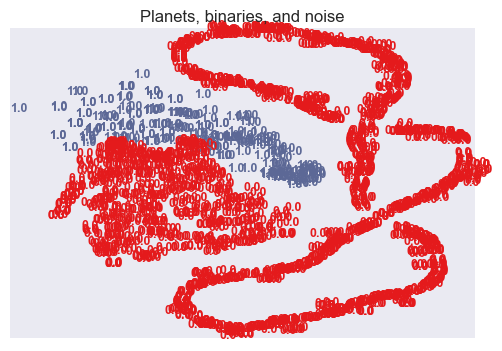

In [59]:
X_planets_binaries = tsne.fit_transform(tsvd.fit_transform(X[:1725, 3:]))

# X_noise = tsne.fit_transform(StandardScaler().fit_transform(X[1225:1725, 3:]))

# X_planets_binaries_noise = np.vstack((X_planets_binaries, X_noise))

plot_embedding(X_planets_binaries, Title="Planets, binaries, and noise")

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=25).fit(X_planets_binaries)

palette = sns.color_palette()

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(X_planets_binaries.T[0], X_planets_binaries.T[1],
            c = cluster_colors)
plt.axis('off')

n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)

print("There are {0} clusters").format(n_clusters_)

plt.show()

We see it picks out the non-exoplanet transits, but the noise consumes the main group of ones. 

Controlling for this noise would be extremely difficult, as in a real set we would have no lablels.

References: 

Packages and plotting function used are from scikit-learn:

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.


HDBScan: 

http://hdbscan.readthedocs.io/en/latest/
https://github.com/scikit-learn-contrib/hdbscan